In [790]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings('ignore')


# Reading and Understanding the data

In [791]:
# Read the dataset
data_frame_bikes = pd.read_csv("day.csv")
data_frame_bikes.head(5)
# 5 is Sunday

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [792]:
data_frame_bikes.shape


(730, 16)

In [793]:
# Drop Columns which are of no use for this case study 
data_frame_bikes=data_frame_bikes.drop(['instant','dteday','casual','registered'], axis=1)
data_frame_bikes.shape

(730, 12)

In [794]:
data_frame_bikes.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


In [795]:
data_frame_bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


At the end of this phase here are a few things we were able to infer and do :
- No null values in the data set
- The fields like instant, dteday , casual and registered have no meaning in the analysis, hence removed
- casual and registered are aggregated into cnt which is our target variable
- instant is primary key , hence no use for analysis
- dteday is date which has no significance here as ll the date related derived fields already present


### Visualize data through scatter plots

<Figure size 2000x5000 with 0 Axes>

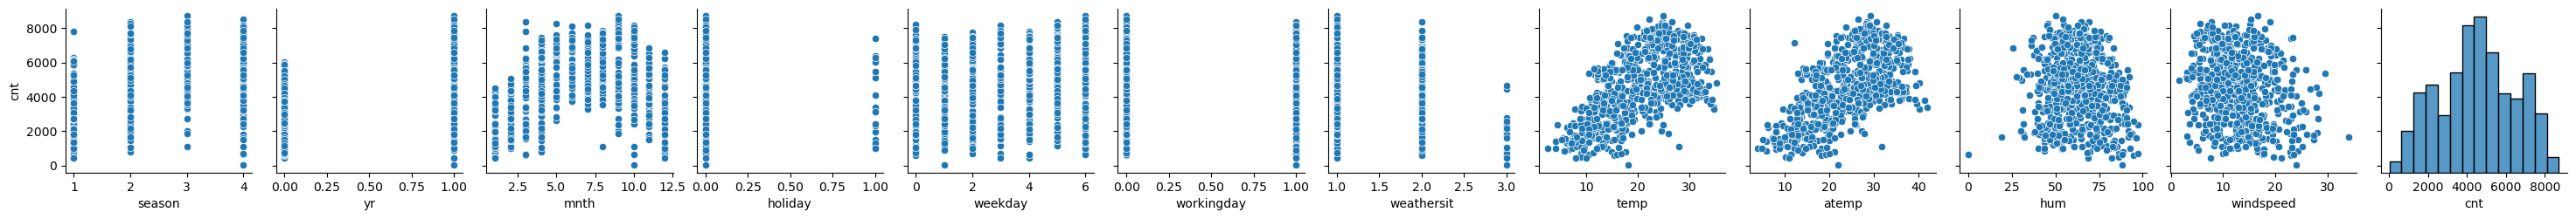

In [796]:
# Visualization
#x_vars=['windspeed','hum','atemp','temp'],y_vars='cnt'
plt.figure(figsize=(20,50))
sns.pairplot(data=data_frame_bikes, y_vars='cnt')
plt.show()

#### Useful Functions used in the notebook

In [797]:
# create subplots
def plot_subplots(df, field_name, target_field, row, column, index):
    plt.subplot(row,column,index)
    sns.boxplot(x=field_name, y=target_field, data=df)

# get statsmodel based linear model 
def get_sm_linear_model(df_X_train,y_training_data_set):
    # Add a constant 
    df_X_train_sm = sm.add_constant(df_X_train)
    linear_regression = sm.OLS(y_training_data_set,df_X_train_sm)
    linear_model = linear_regression.fit()
    return linear_model, df_X_train_sm

# create labels for categorical data 
def create_category_labels(data_frame, field_name, dict_value_label):
    for key in dict_value_label.keys():
        data_frame.loc[data_frame[field_name] == key,field_name] = dict_value_label[key]
        
# remove column from data_frame , field_name is a string value        
def remove_field(df, field_name):
    df.drop([field_name], axis=1, inplace=True)

# remove columns from data_frame , field_names is a list    
def remove_fields(df, field_names):
    df.drop(field_names, axis=1 ,inplace=True)
    
def get_vif(df):
    vif = pd.DataFrame()    
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by="VIF", ascending=False)
    return vif             

The Above functions are used repeatedly in the notebook , hence they have been collected at the top

In [798]:
# Converting Ordinal variables to represent data in box plots, Later they will be of use in dummy variables
#Create Dictionaries for Categorical Variables    
dict_season={1:"spring",2:"summer",3:"autumn",4:"winter"}
dict_month={1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
dict_weekday={1:"Wed",2:"Thu",3:"Fri",4:"Sat",5:"Sun",6:"Mon",0:"Tue"}
dict_weathersit={1:"Clear",2:"Misty",3:"Snow",4:"Rain"}
dict_year={0:"2018",1:"2019"}

#Apply Function on them to Create meaningful Labels
create_category_labels(data_frame_bikes,"season",dict_season)
create_category_labels(data_frame_bikes,"mnth",dict_month)
create_category_labels(data_frame_bikes,"weekday",dict_weekday)
create_category_labels(data_frame_bikes,"weathersit",dict_weathersit)
create_category_labels(data_frame_bikes,"yr",dict_year)


In [799]:
data_frame_bikes.head()  

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,Jan,0,Mon,0,Misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,Jan,0,Tue,0,Misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


### Create Box plots for categorical variables

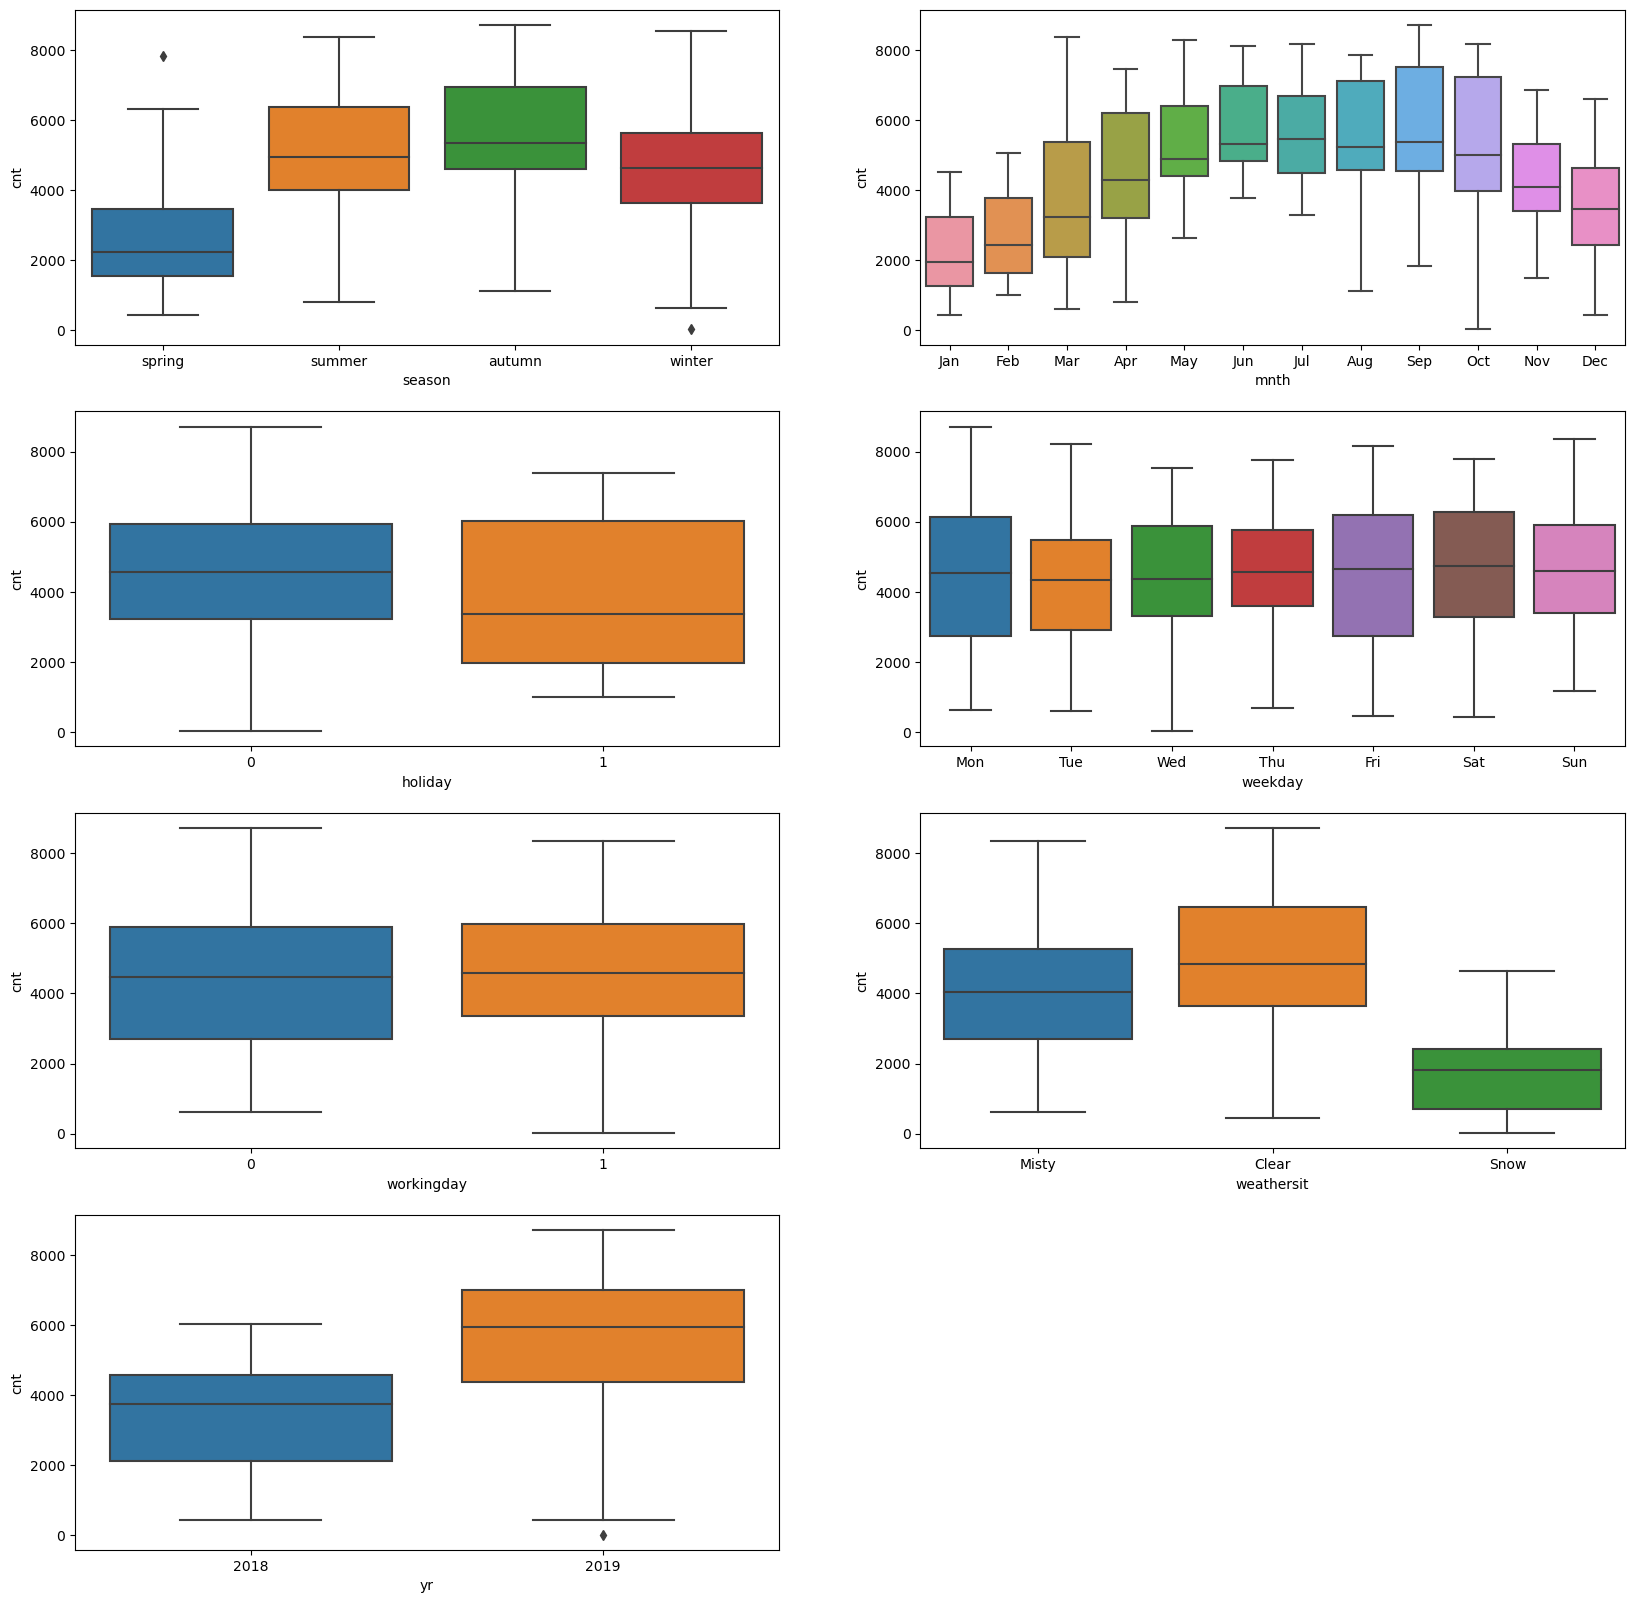

In [800]:
plt.figure(figsize=(20,20))
plot_subplots(data_frame_bikes,"season","cnt",4,2,1)
plot_subplots(data_frame_bikes,"mnth","cnt",4,2,2)
plot_subplots(data_frame_bikes,"holiday","cnt",4,2,3)
plot_subplots(data_frame_bikes,"weekday","cnt",4,2,4)
plot_subplots(data_frame_bikes,"workingday","cnt",4,2,5)
plot_subplots(data_frame_bikes,"weathersit","cnt",4,2,6)
plot_subplots(data_frame_bikes,"yr","cnt",4,2,7)



#### The data analysis based on box plots through some interesting facts:
- the demand wrt months is defintely seeing a trend wherein we see that it peaks in summers and is lowest in the winter months 
- weather when its snowing the demand considerable decreases as people not willing to use bikes in snow
- the demand for bikes is definitely higher on a non holiday than on a holiday , possibly as people may like to stay at home or spend more time with family
- the demand for bikes in considerably lower in Spring months . This is contrary to what we expect , but seems like people prefer to say home and work

# Step 2 : Preparing the data for Modelling

In [801]:
# Encoding binary conversion
data_frame_bikes['yr']=data_frame_bikes['yr'].map({"2018":0,"2019":1})
data_frame_bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Mon,0,Misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,0,Misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [802]:

# Encoding multiple ordinal variables 
ordinal_variables = ['season','mnth','weekday','weathersit']
data_frame_bikes_encoded = pd.get_dummies(data=data_frame_bikes,columns=ordinal_variables,drop_first=True)
data_frame_bikes_encoded.head() 
# Encoding complete

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Misty,weathersit_Snow
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,0,0,0


In [803]:
data_frame_bikes_encoded.columns


Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_spring', 'season_summer', 'season_winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'weekday_Mon',
       'weekday_Sat', 'weekday_Sun', 'weekday_Thu', 'weekday_Tue',
       'weekday_Wed', 'weathersit_Misty', 'weathersit_Snow'],
      dtype='object')

In [804]:
len(data_frame_bikes_encoded.columns)


30

In [805]:

# Remove Dummy Variable Trap 
# data_frame_bikes_encoded=data_frame_bikes_encoded.drop(['season_spring','mnth_Jan','weekday_Tue','weathersit_Snow'], axis=1)


In [806]:
len(data_frame_bikes_encoded.columns)


30

### Correlation between all variables


<AxesSubplot:>

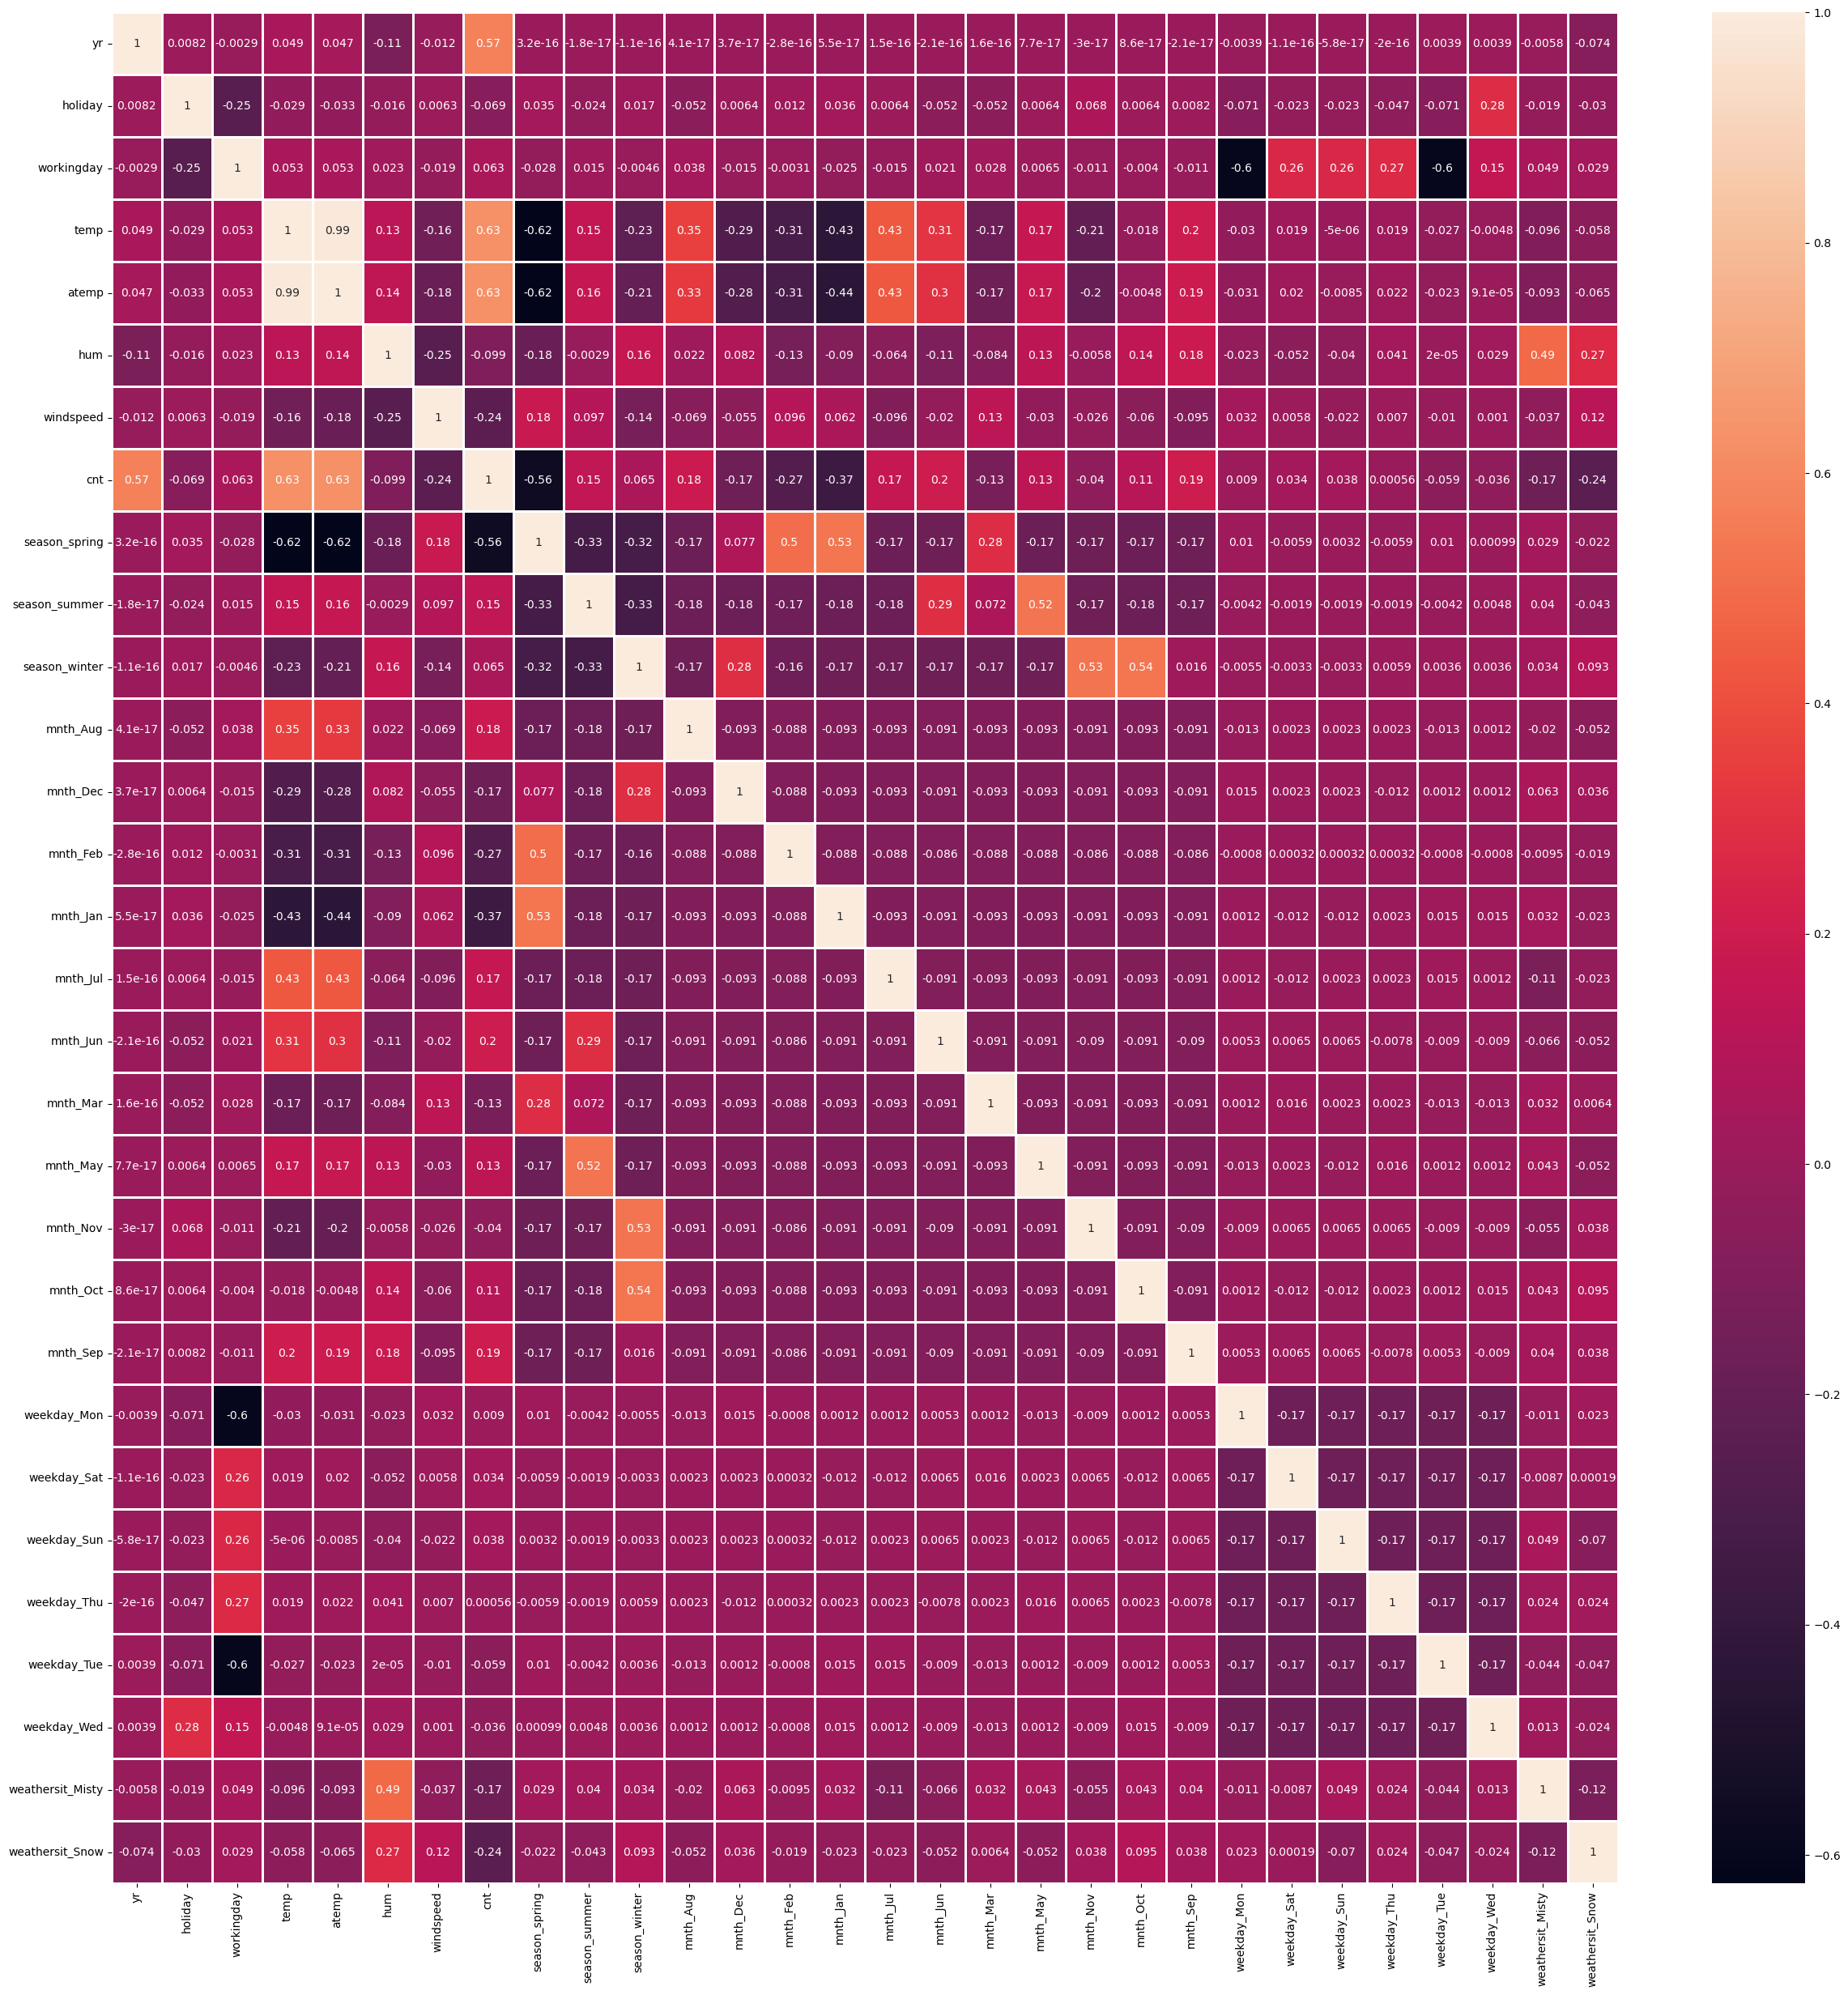

In [807]:
fig, ax = plt.subplots(figsize=(30,30)) 
sns.heatmap(data_frame_bikes_encoded.corr(),annot=True,linewidths=.9, ax=ax)

In [808]:
# remove atemp as it has 0.99 correlation
data_frame_bikes_encoded=data_frame_bikes_encoded.drop(['atemp'], axis=1)
print(data_frame_bikes_encoded.columns)


Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'season_spring', 'season_summer', 'season_winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'weekday_Mon',
       'weekday_Sat', 'weekday_Sun', 'weekday_Thu', 'weekday_Tue',
       'weekday_Wed', 'weathersit_Misty', 'weathersit_Snow'],
      dtype='object')


### Splitting into Train and Test

In [809]:
np.random.seed(0)
data_frame_training_set, data_frame_test_set = train_test_split(data_frame_bikes_encoded, train_size=0.7,test_size=0.3, random_state=100)
print(data_frame_training_set.shape)
print(data_frame_test_set.shape)

(510, 29)
(219, 29)


### Rescaling the features
#### normalisation (x - xmin)/(xmax - xmin)
#### standardisation ((x-mu)/sigma)

In [810]:
# Instantiate an object 
scaler = MinMaxScaler()

# Create a list of numeric
fields_numeric = ['temp','hum','windspeed','cnt']
# Fit the data 

data_frame_training_set[fields_numeric] = scaler.fit_transform(data_frame_training_set[fields_numeric])


In [811]:
data_frame_training_set.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Misty,weathersit_Snow
653,1,0,1,0.509887,0.575354,0.300794,0.864243,0,0,1,...,1,0,0,0,0,1,0,0,0,0
576,1,0,1,0.815169,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,1,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0.465255,1,0,0,...,0,0,1,0,0,0,0,0,1,0
728,1,0,0,0.245101,0.498067,0.663106,0.204096,1,0,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.482973,0,1,0,...,0,0,1,0,0,0,0,0,1,0


## Step 3 Training the Model

In [812]:
y_training_data_set = data_frame_training_set.pop('cnt')
X_train = data_frame_training_set
X_train.head()
X_train.shape



(510, 28)

In [813]:
# Create Linear Model

linear_model ,X_train_sm = get_sm_linear_model(X_train,y_training_data_set)
linear_model.params


const               0.242930
yr                  0.232116
holiday             0.006726
workingday          0.093651
temp                0.450562
hum                -0.151340
windspeed          -0.186453
season_spring      -0.048159
season_summer       0.038725
season_winter       0.105847
mnth_Aug            0.014404
mnth_Dec           -0.045586
mnth_Feb           -0.032282
mnth_Jan           -0.062777
mnth_Jul           -0.040350
mnth_Jun           -0.002972
mnth_Mar            0.001045
mnth_May            0.023940
mnth_Nov           -0.041851
mnth_Oct            0.007534
mnth_Sep            0.081060
weekday_Mon         0.098544
weekday_Sat        -0.003849
weekday_Sun         0.005388
weekday_Thu        -0.013502
weekday_Tue         0.044008
weekday_Wed        -0.015519
weathersit_Misty   -0.061066
weathersit_Snow    -0.257443
dtype: float64

In [814]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     103.8
Date:                Mon, 12 Dec 2022   Prob (F-statistic):          8.74e-182
Time:                        16:31:14   Log-Likelihood:                 527.95
No. Observations:                 510   AIC:                            -999.9
Df Residuals:                     482   BIC:                            -881.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2429      0.035      6.854      0.000       0.173       0.313
yr                   0.2321      0.008     28.820      0.000       0.216       0.248
holiday              0.0067      0.024      0.278      0.781      -0.041       0.054
workingday           0.0937      0.012      7.783      0.000       0.070       0.117
temp                 0.4506      0.046      9.734      0.000       0.360       0.542
hum                 -0.1513      0.038     -3.933      0.000      -0.227      -0.076
windspeed           -0.1865      0.026     -7.257      0.000      -0.237      -0.136
season_spring       -0.0482      0.030     -1.607      0.109      -0.107       0.011
season_summer        0.0387      0.026      1.478      0.140      -0.013       0.090
season_winter        0.1058      0.028      3.794      0.000       0.051       0.161
mnth_Aug             0.0144      0.034      0.428      0.669      -0.052       0.081
mnth_Dec            -0.0456      0.034     -1.358      0.175      -0.112       0.020
mnth_Feb            -0.0323      0.033     -0.982      0.327      -0.097       0.032
mnth_Jan            -0.0628      0.034     -1.873      0.062      -0.129       0.003
mnth_Jul            -0.0404      0.035     -1.151      0.250      -0.109       0.029
mnth_Jun            -0.0030      0.025     -0.119      0.906      -0.052       0.046
mnth_Mar             0.0010      0.025      0.043      0.966      -0.047       0.049
mnth_May             0.0239      0.021      1.140      0.255      -0.017       0.065
mnth_Nov            -0.0419      0.036     -1.152      0.250      -0.113       0.030
mnth_Oct             0.0075      0.036      0.211      0.833      -0.063       0.078
mnth_Sep             0.0811      0.032      2.533      0.012       0.018       0.144
weekday_Mon          0.0985      0.013      7.300      0.000       0.072       0.125
weekday_Sat         -0.0038      0.015     -0.263      0.793      -0.033       0.025
weekday_Sun          0.0054      0.015      0.362      0.718      -0.024       0.035
weekday_Thu         -0.0135      0.015     -0.917      0.359      -0.042       0.015
weekday_Tue          0.0440      0.014      3.213      0.001       0.017       0.071
weekday_Wed         -0.0155      0.015     -1.064      0.288      -0.044       0.013
weathersit_Misty    -0.0611      0.010     -5.854      0.000      -0.082      -0.041
weathersit_Snow     -0.2574      0.026     -9.778      0.000      -0.309      -0.206
==============================================================================
Omnibus:                       84.475   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.382
Skew:                          -0.804   Prob(JB):                     7.72e-52
Kurtosis:                       5.914   Cond. N

The adjusted R square is **84.5%**
We need to analyse further 

## Apply RFE on the set to evaluate further

We select top 15 features and try to see the correlation further



In [815]:
linear_regression = LinearRegression()
rfe_model_15 = RFE(linear_regression, n_features_to_select=15,step=1)

In [816]:
# Fit with 15 features
rfe_model_15.fit(X_train, y_training_data_set)

# Print the boolean results
print(rfe_model_15.support_)           
print(rfe_model_15.ranking_)  


[ True  True  True  True  True  True  True  True  True False False False
  True  True False False False False False  True  True False False False
 False False  True  True]
[ 1  1  1  1  1  1  1  1  1  6  3  4  1  1 13 14  5  2 10  1  1 12 11  9
  7  8  1  1]


#### Check the model with these 15 parameters


In [817]:
columns_RFE = X_train.columns[rfe_model_15.support_]
print(columns_RFE)

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_spring', 'season_summer', 'season_winter', 'mnth_Jan',
       'mnth_Jul', 'mnth_Sep', 'weekday_Mon', 'weathersit_Misty',
       'weathersit_Snow'],
      dtype='object')


In [818]:
# extract dataframe for those columns
data_frame_X_training_rfe = X_train[columns_RFE]

# Add a constant 
data_frame_X_training_rfe_sm = sm.add_constant(data_frame_X_training_rfe)

data_frame_X_training_rfe_sm.head()

,const,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_Jan,mnth_Jul,mnth_Sep,weekday_Mon,weathersit_Misty,weathersit_Snow
653,1.0,1,0,1,0.509887,0.575354,0.300794,0,0,1,0,0,0,0,0,0
576,1.0,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,1,0,0,0,0
426,1.0,1,0,0,0.442393,0.640189,0.255342,1,0,0,0,0,0,1,1,0
728,1.0,1,0,0,0.245101,0.498067,0.663106,1,0,0,0,0,0,0,0,0
482,1.0,1,0,0,0.395666,0.504508,0.188475,0,1,0,0,0,0,1,1,0


In [819]:
linear_regression_2 = sm.OLS(y_training_data_set,data_frame_X_training_rfe_sm)
linear_model_2 = linear_regression_2.fit()
print(linear_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.6
Date:                Mon, 12 Dec 2022   Prob (F-statistic):          2.31e-191
Time:                        16:31:14   Log-Likelihood:                 519.88
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     494   BIC:                            -940.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2510      0.036  

*** No significant drops are observed 
So we can say that these 15 parameters do not change the outcome considerably 

In [820]:
# Signifance of variables (p -values)
# VIF 
print(get_vif(data_frame_X_training_rfe_sm))


            Features    VIF
0              const  84.59
7      season_spring   5.08
4               temp   3.89
9      season_winter   3.60
8      season_summer   2.64
5                hum   1.92
3         workingday   1.88
13       weekday_Mon   1.78
10          mnth_Jan   1.57
14  weathersit_Misty   1.57
11          mnth_Jul   1.49
12          mnth_Sep   1.30
15   weathersit_Snow   1.25
6          windspeed   1.21
2            holiday   1.16
1                 yr   1.04


In [821]:
#Drop the constant
remove_field(data_frame_X_training_rfe_sm, 'const')
print(get_vif(data_frame_X_training_rfe_sm))


            Features    VIF
4                hum  29.40
3               temp  17.77
2         workingday   5.31
5          windspeed   4.73
6      season_spring   4.53
8      season_winter   3.48
7      season_summer   2.84
13  weathersit_Misty   2.29
0                 yr   2.09
12       weekday_Mon   1.98
9           mnth_Jan   1.67
10          mnth_Jul   1.59
11          mnth_Sep   1.39
14   weathersit_Snow   1.25
1            holiday   1.18


In [822]:
# Remove the temp
remove_field(data_frame_X_training_rfe_sm, 'temp')
print(get_vif(data_frame_X_training_rfe_sm))

            Features    VIF
3                hum  11.70
2         workingday   5.00
4          windspeed   4.39
5      season_spring   3.23
6      season_summer   2.67
7      season_winter   2.54
0                 yr   1.97
12  weathersit_Misty   1.94
11       weekday_Mon   1.91
8           mnth_Jan   1.60
9           mnth_Jul   1.47
10          mnth_Sep   1.39
1            holiday   1.17
13   weathersit_Snow   1.13


In [823]:
# Remove the hum
remove_field(data_frame_X_training_rfe_sm, 'hum')
print(get_vif(data_frame_X_training_rfe_sm))


            Features   VIF
3          windspeed  4.27
2         workingday  3.83
4      season_spring  2.97
5      season_summer  2.27
6      season_winter  1.99
0                 yr  1.91
10       weekday_Mon  1.69
7           mnth_Jan  1.60
11  weathersit_Misty  1.56
8           mnth_Jul  1.30
9           mnth_Sep  1.25
1            holiday  1.13
12   weathersit_Snow  1.08


In [824]:
# df_X_train_vif
# lets ccheck the Linear Model again 
linear_model_3, data_frame_final_set = get_sm_linear_model(data_frame_X_training_rfe_sm,y_training_data_set)
print(linear_model_3.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     136.0
Date:                Mon, 12 Dec 2022   Prob (F-statistic):          4.04e-154
Time:                        16:31:58   Log-Likelihood:                 425.72
No. Observations:                 510   AIC:                            -823.4
Df Residuals:                     496   BIC:                            -764.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5448      0.020  

In [825]:
data_frame_final_set.shape


(510, 14)

# Residual Analysis

<AxesSubplot:ylabel='Density'>

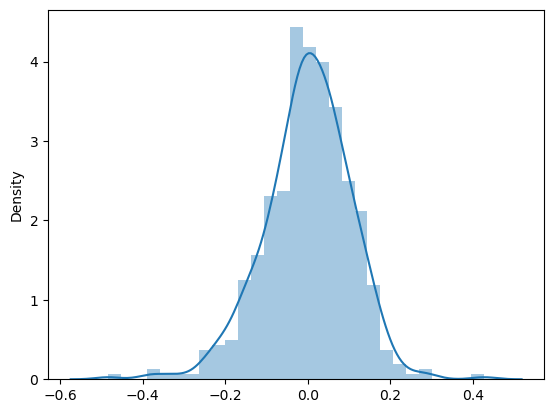

In [826]:
y_training_data_seting_set_predicted = linear_model_3.predict(data_frame_final_set)
res= y_training_data_set - y_training_data_seting_set_predicted
sns.distplot(res)

# Step 4 Prediction and Evaluation 

In [827]:
# Replicate steps for Training Set on Test Set 
data_frame_test_set.head()

# scaled columns_list
data_frame_test_set.columns

scaled_columns = ['temp','hum','windspeed','cnt']


In [828]:
#scale
data_frame_test_set[scaled_columns] = scaler.transform(data_frame_test_set[scaled_columns])


In [829]:
y_test = data_frame_test_set.pop('cnt')


In [830]:
# get columns from final model
data_frame_final_set.columns

data_frame_final_set_model = data_frame_final_set.drop(['const'],axis=1)
data_frame_test_set

,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_Aug,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Misty,weathersit_Snow
184,0,1,0,0.831783,0.657364,0.084219,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
535,1,0,1,0.901354,0.610133,0.153728,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
299,0,0,1,0.511964,0.837699,0.334206,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
221,0,0,1,0.881625,0.437098,0.339570,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,0.817246,0.314298,0.537414,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1,0,0,0.257562,0.708888,0.287411,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
702,1,0,1,0.519232,0.756118,0.283397,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
127,0,0,0,0.584649,0.650923,0.069510,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
640,1,0,1,0.745598,0.817947,0.052115,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0


<AxesSubplot:>

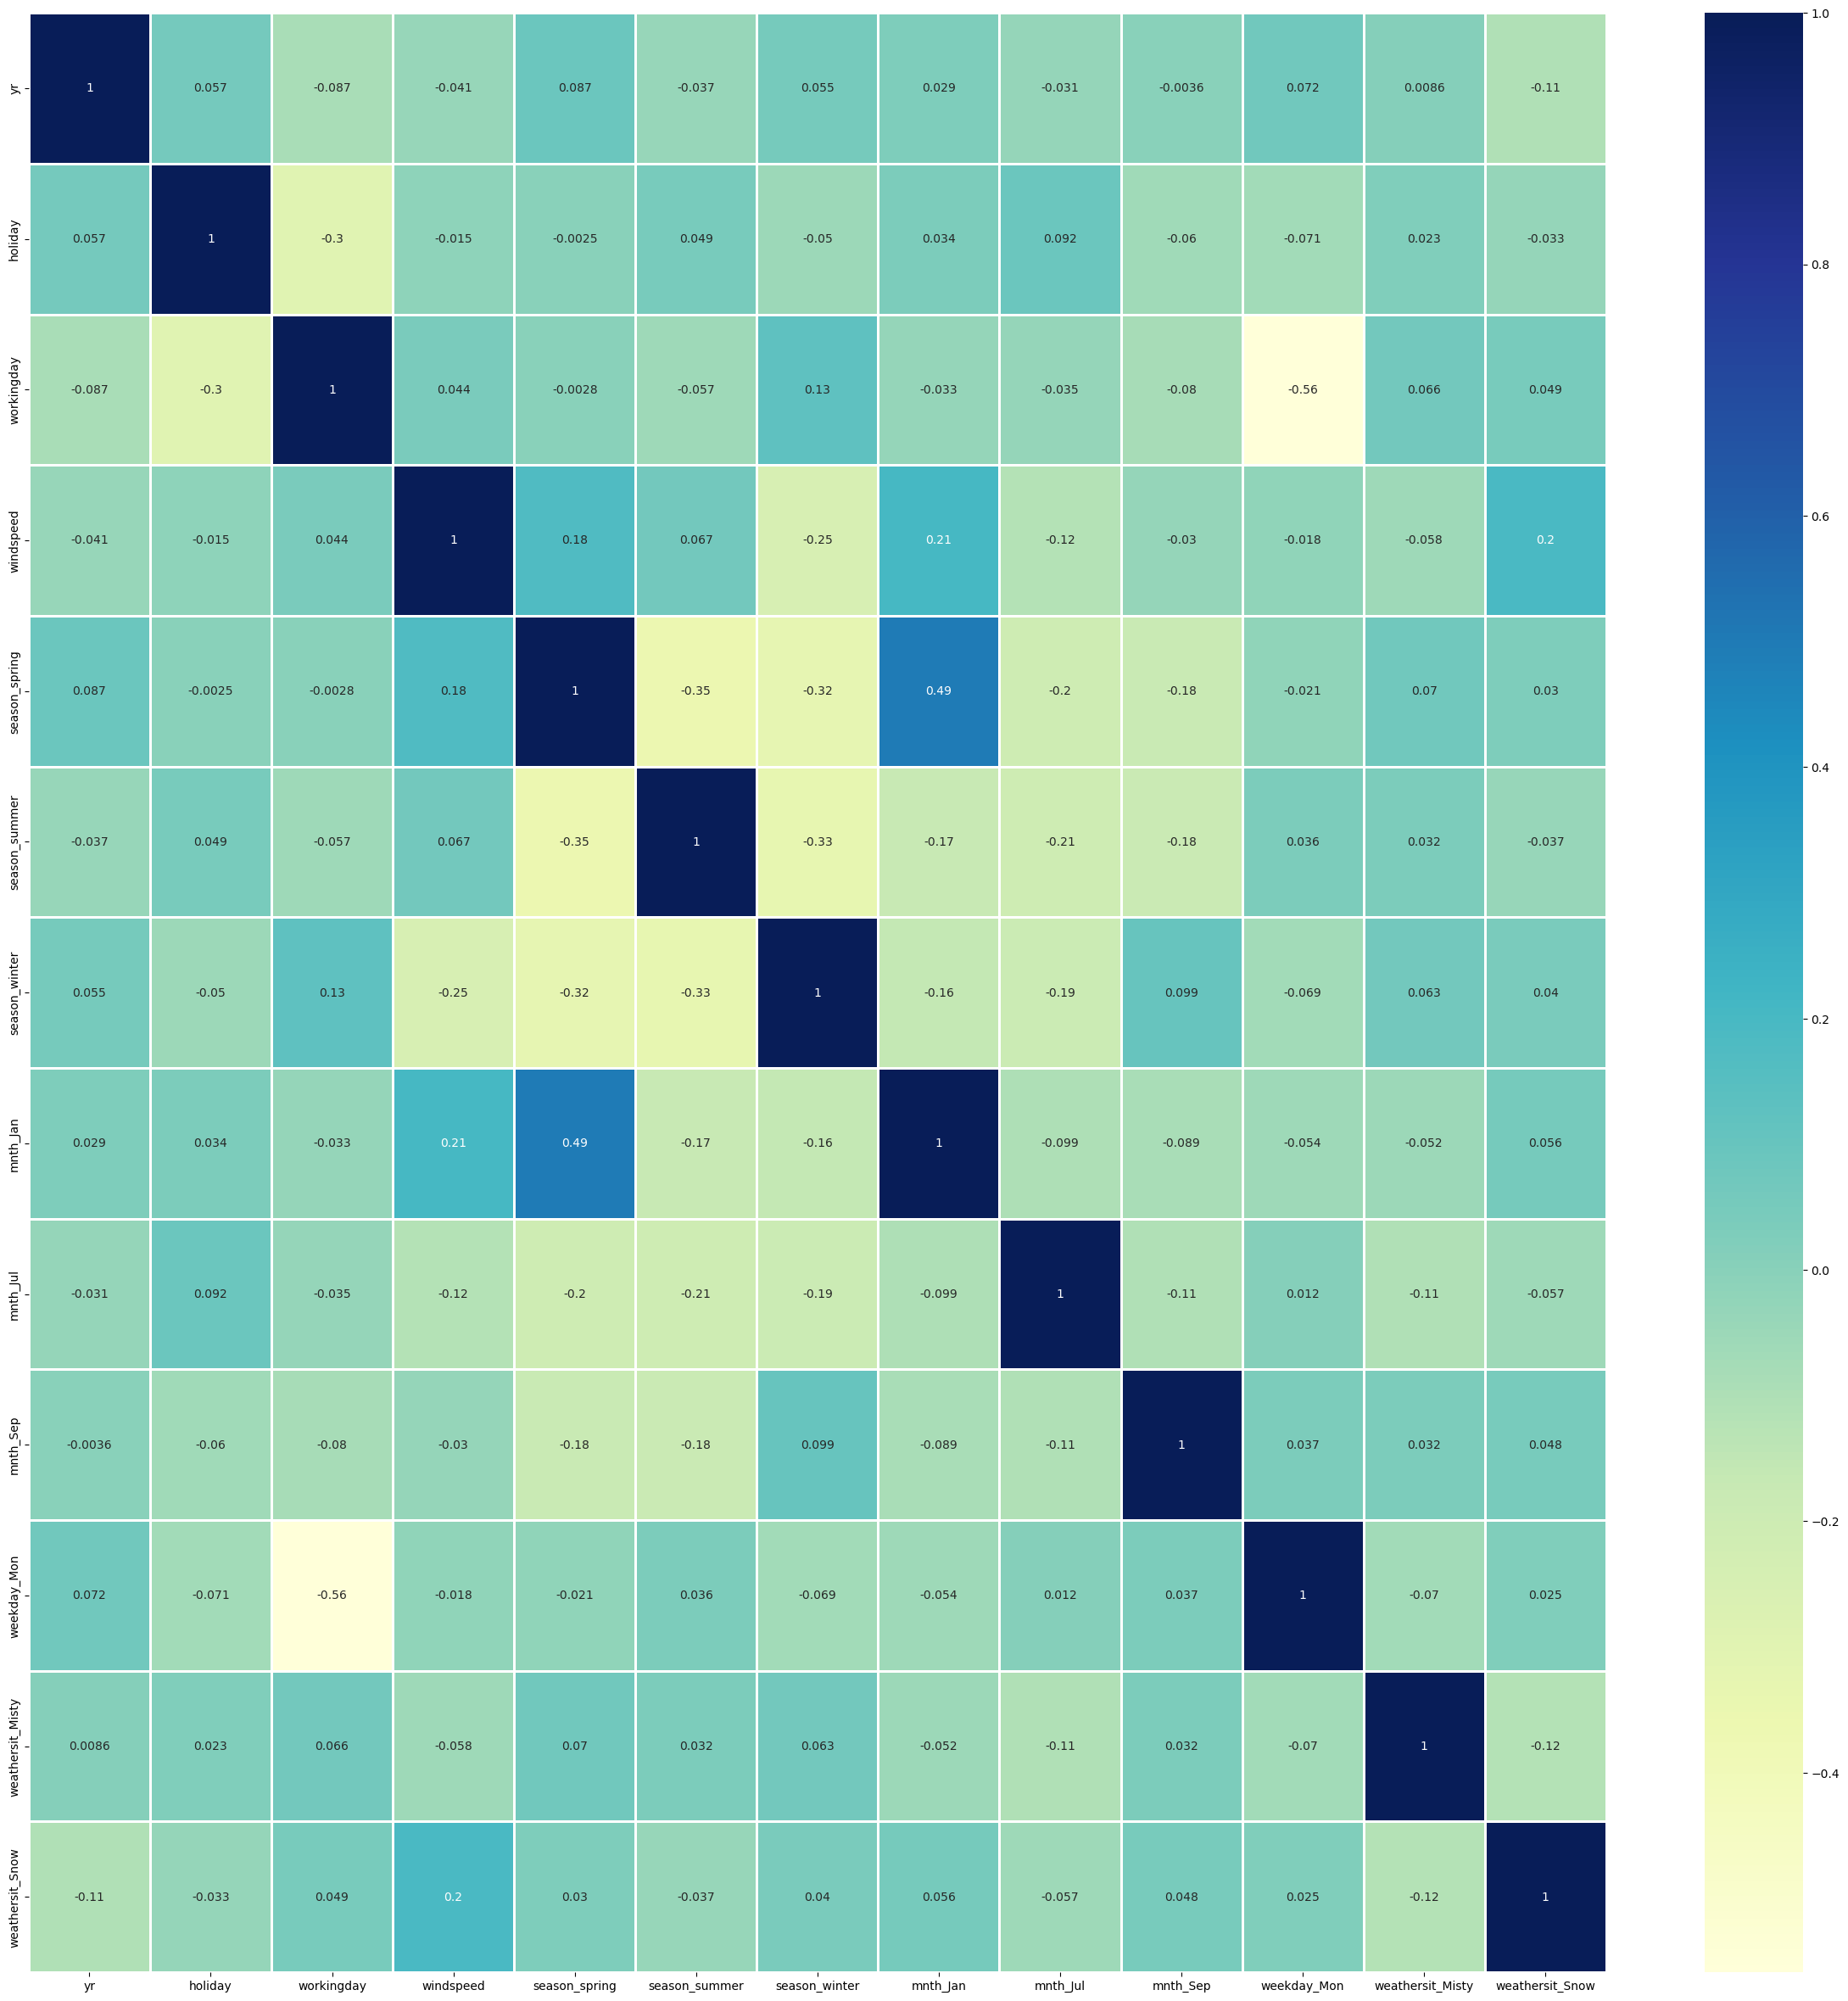

In [834]:
# Predict and Plot
X_test = data_frame_test_set
X_test_rfe_model_15 = X_test[data_frame_final_set_model.columns]
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(X_test_rfe_model_15.corr(),annot=True,linewidths=.9, ax=ax, cmap="YlGnBu")



Text(0, 0.5, 'y_pred')

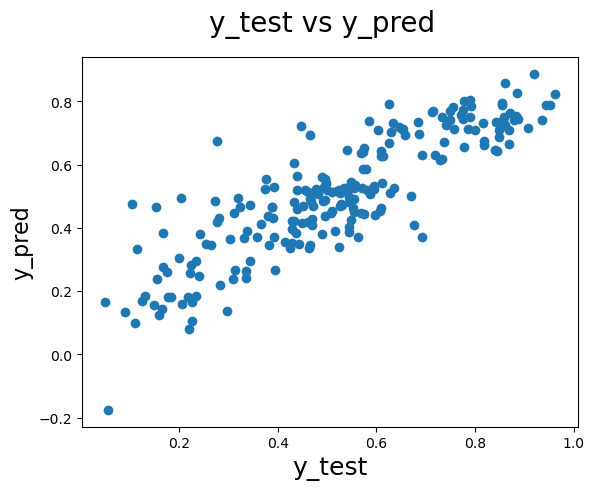

In [832]:


X_test_rfe_model_15 = sm.add_constant(X_test_rfe_model_15)
X_test_rfe_model_15.columns
y_pred = linear_model_3.predict(X_test_rfe_model_15)
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)  


In [833]:

r2_score(y_test, y_pred)

0.7387457850512258

The model seems to fit into a straight line , clearly through scatter plot we can see that this more or less suits the model